# Download needed libraries


In [1]:
%pip install matplotlib wordcloud
%pip install sentence_transformers
%pip install hdbscan
%pip install --upgrade openai==0.28


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

#Importing the libraries

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import umap
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pickle
import shutil
import matplotlib.pyplot as plt
import openai
from collections import Counter
import random



#Data Preprocessing

## Downloading wordnet and stopwords packages, load the dataset

In [3]:
# Download NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

# Load dataset
data = pd.read_csv('1429_1 - Copy.csv')  # Replace with your file path

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
data['name'].head(33000)

0        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
1        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
2        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
3        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
4        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
                               ...                        
32995                                                  NaN
32996                                                  NaN
32997                                                  NaN
32998                                                  NaN
32999                                                  NaN
Name: name, Length: 33000, dtype: object

### Show the nan values in the dataset categories feature

In [5]:
# Count NaN values in 'categories'
categories_nan_count = data['categories'].isna().sum()
print(f"Number of NaN values in 'categories' column: {categories_nan_count}")
product_nan_count = data['name'].isna().sum()
print(f"Number of NaN values in 'name' column: {product_nan_count}")


Number of NaN values in 'categories' column: 0
Number of NaN values in 'name' column: 6760


###Remove the nan values

In [6]:
# Handle NaN values explicitly
print("Handling NaN values...")
data = data.dropna(subset=['name'])
data = data.dropna(subset=['categories'])

Handling NaN values...


### clean the categories feature from the stopwords, the punctutaions and split it

In [7]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    # Convert to lowercase
    text = text.lower()


    # Remove special characters (keeping letters, spaces, and commas)
    text = re.sub(r'[^a-z\s,]', '', text)

    # Split into categories
    categories = [cat.strip() for cat in text.split(',') if cat.strip()]

    # Process each category
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english') + ['new', 'misc','offer','offers','magenta',
                                                   'fire','special', 'miscellaneous',
                                                   'other', 'includes', 'including',
                                                   'amazon', 'Back','allnew','wifi','hd','gb'
                                                   ,'display','kids','editions','edition','nan'])
    pattern = re.compile('[%s]' % re.escape(string.punctuation))

    cleaned_categories = []
    for cat in categories:
        # Split into words and process each word
        words = cat.split()
        filtered_words = [
            pattern.sub('', word)
            for word in words
            if word not in stop_words and len(word) > 1
        ]
        if filtered_words:
            cleaned_categories.append(' '.join(filtered_words))

    return ', '.join(cleaned_categories)

In [8]:
data['cleaned_combined'] = data['name'].map(clean_text)+" "+data['categories'].map(clean_text)

### Check the dataset balance

<ipython-input-9-88359d708c07>:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


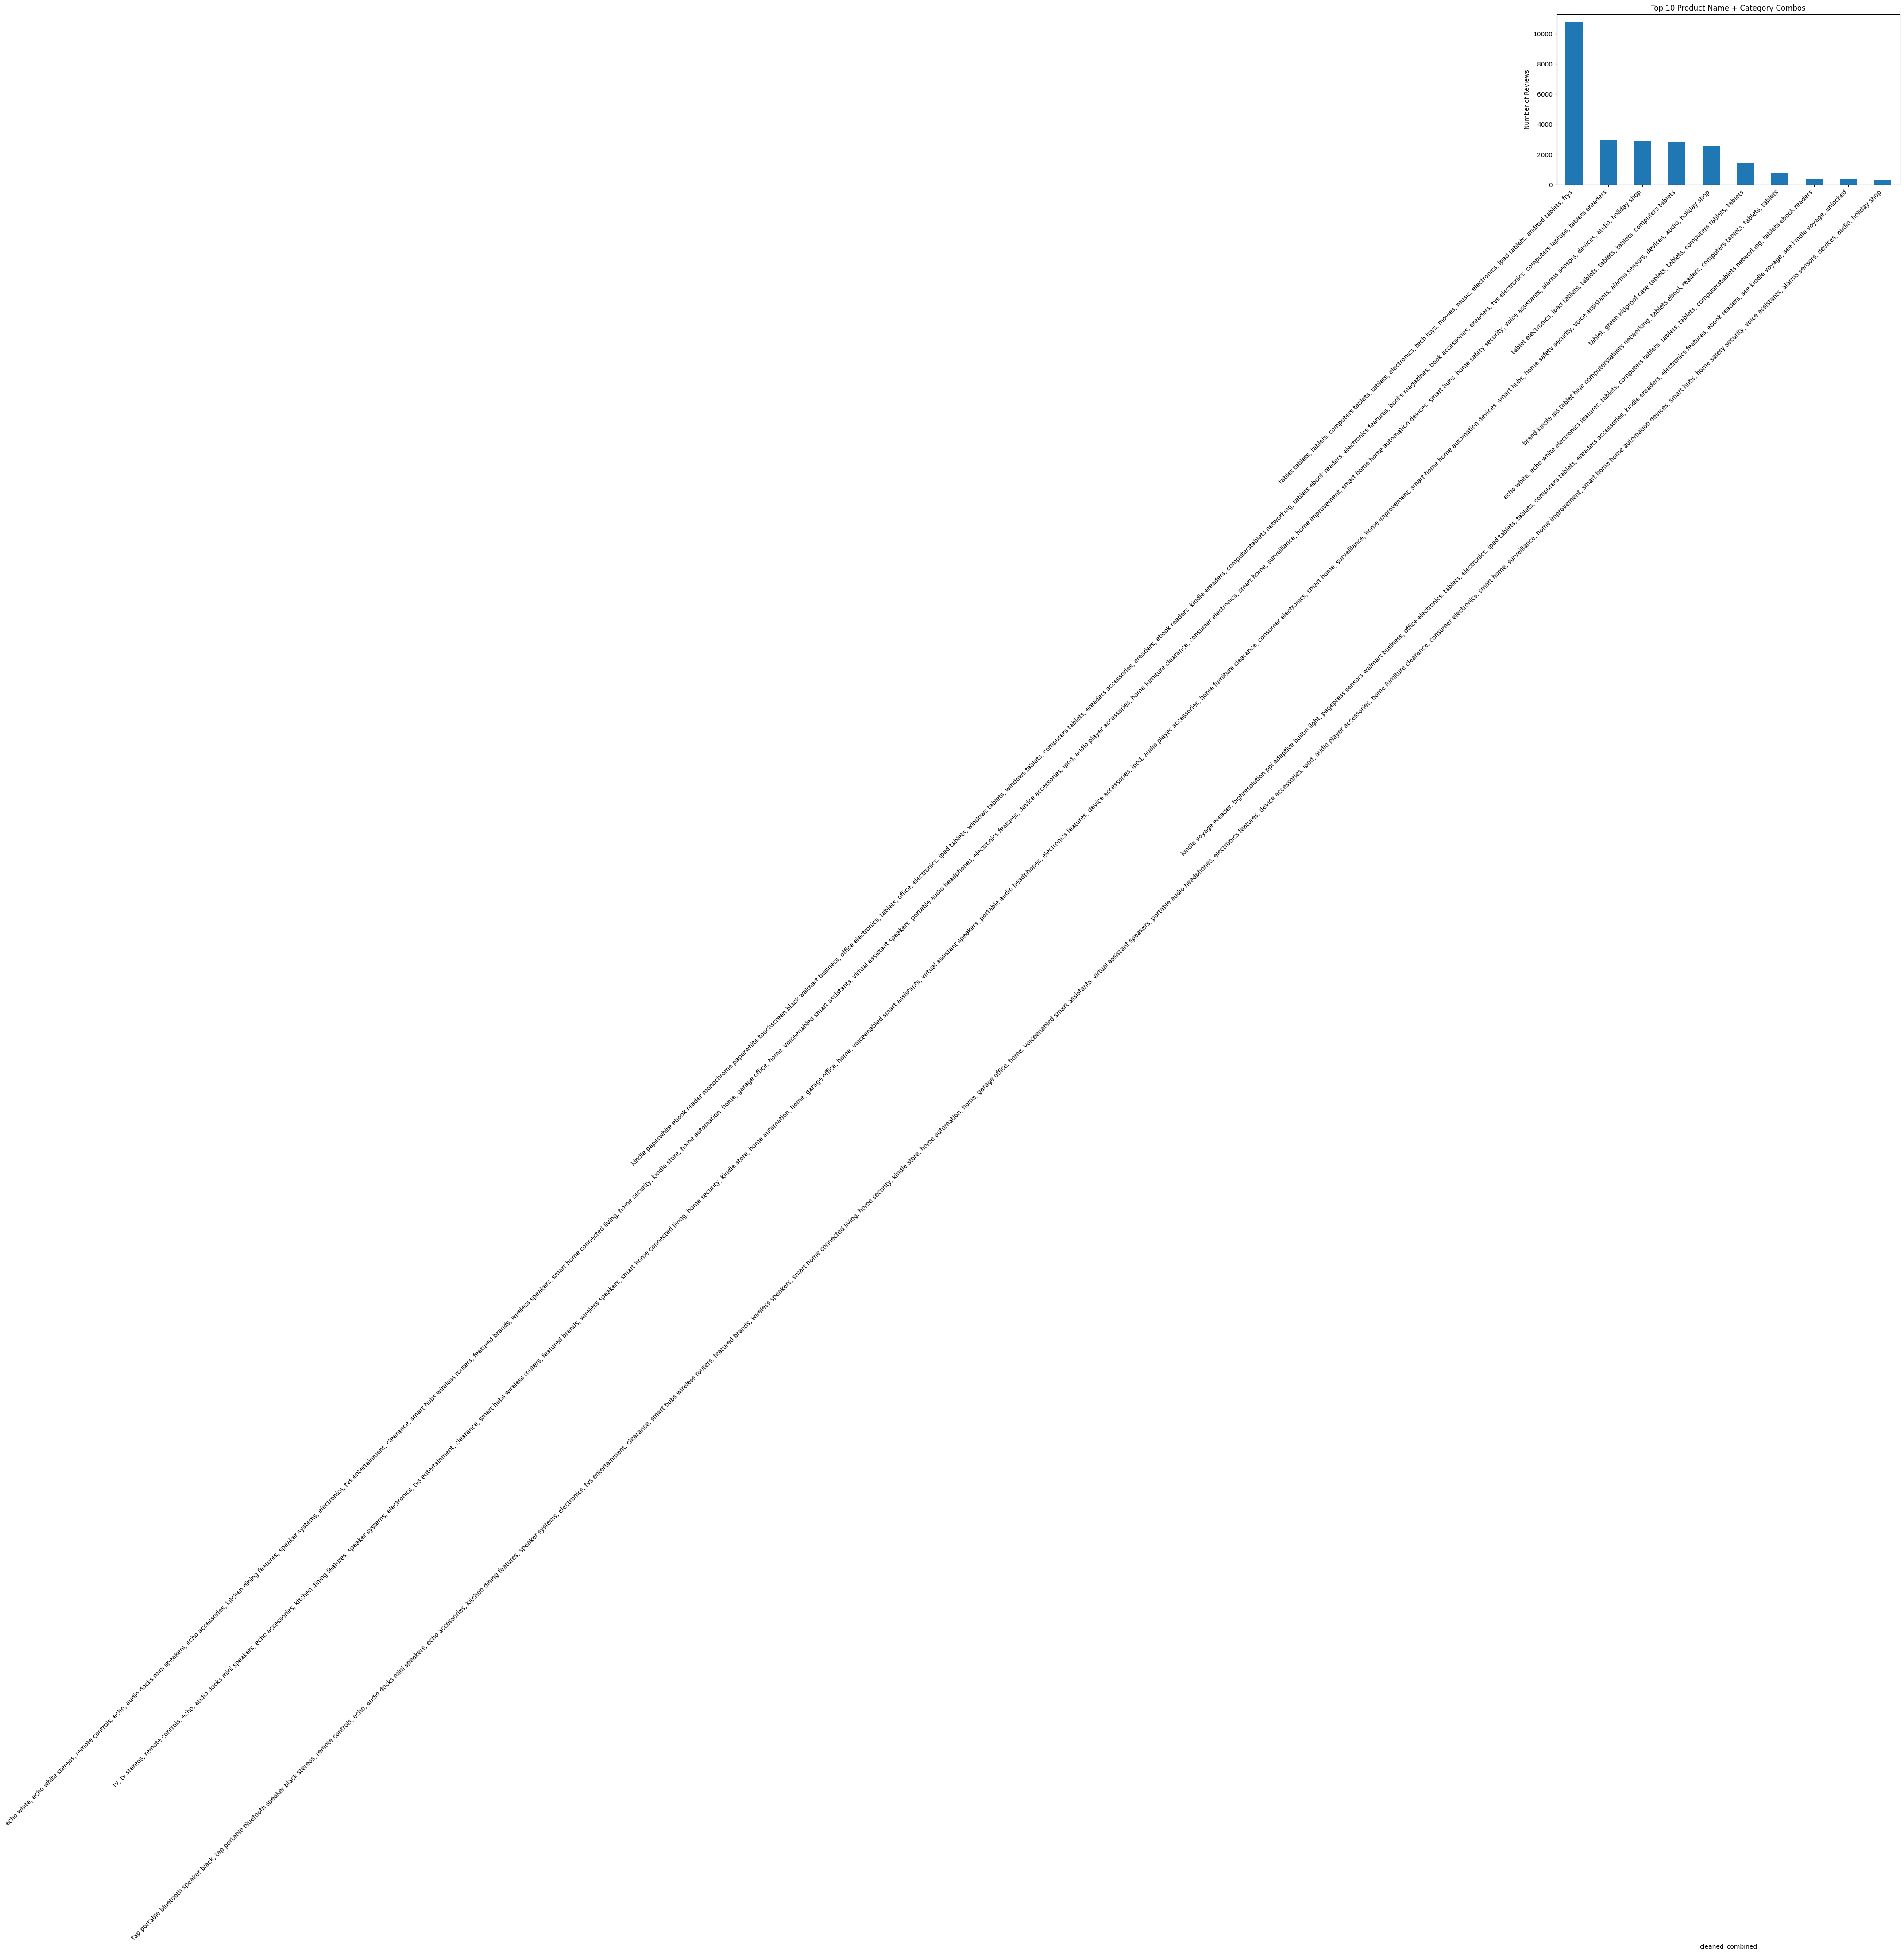

In [9]:
combo_counts = data['cleaned_combined'].value_counts().head(10)

plt.figure(figsize=(10, 5))
combo_counts.plot(kind='bar', title='Top 10 Product Name + Category Combos')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### balance the dataset

In [10]:
# Set max reviews per product (e.g., 1000)
MAX_REVIEWS = 3000

# Undersample each product name
balanced_data = data.groupby('cleaned_combined').apply(lambda x: x.sample(min(len(x), MAX_REVIEWS), random_state=42)).reset_index(drop=True)

# Check result
print("Original dataset size:", len(data))
print("Balanced dataset size:", len(balanced_data))


Original dataset size: 27900
Balanced dataset size: 20149


<ipython-input-10-7a217ac35125>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('cleaned_combined').apply(lambda x: x.sample(min(len(x), MAX_REVIEWS), random_state=42)).reset_index(drop=True)


<ipython-input-11-8e20ba576e19>:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


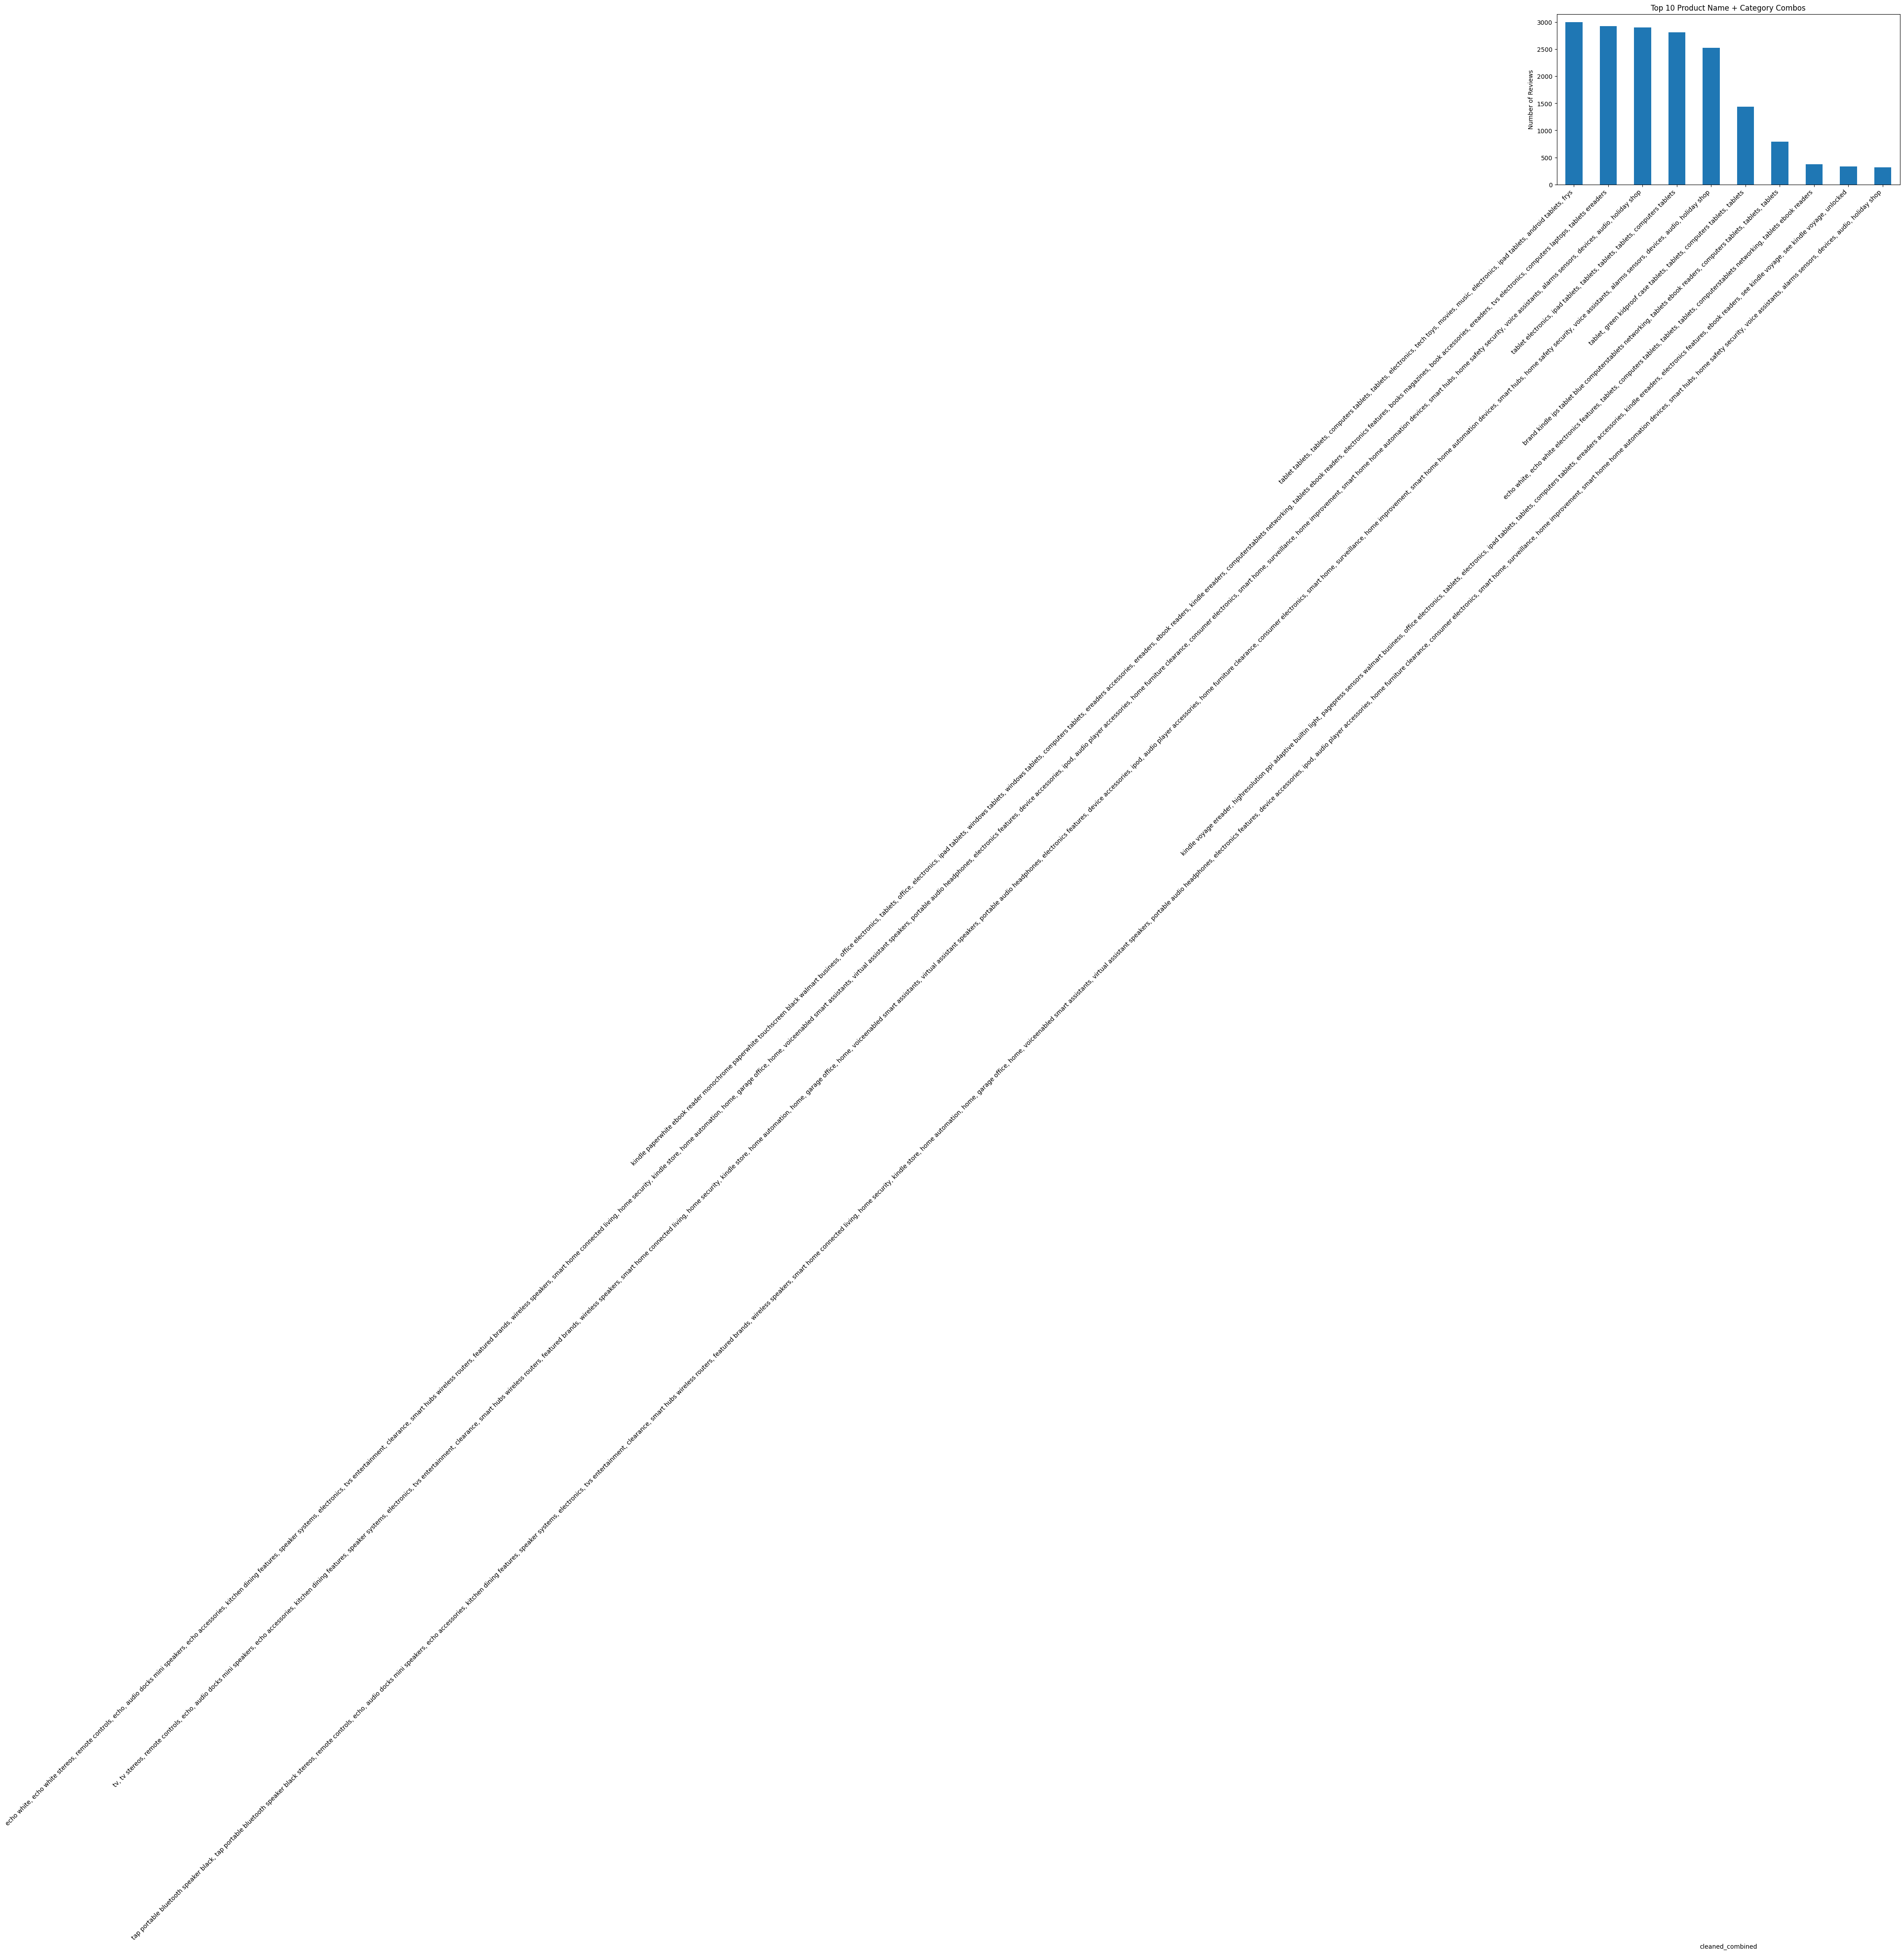

In [11]:
combo_counts = balanced_data['cleaned_combined'].value_counts().head(10)

plt.figure(figsize=(10, 5))
combo_counts.plot(kind='bar', title='Top 10 Product Name + Category Combos')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
balanced_data['cleaned_combined'].head(33110)

0        brand kindle ips tablet blue computers tablets...
1        brand kindle ips tablet blue computers tablets...
2        brand kindle ips tablet blue computers tablets...
3        brand kindle ips tablet blue computers tablets...
4        brand kindle ips tablet blue computers tablets...
                               ...                        
20144    usb official oem charger power adapter tablets...
20145    usb official oem charger power adapter tablets...
20146    usb official oem charger power adapter tablets...
20147    usb official oem charger power adapter tablets...
20148    usb official oem charger power adapter tablets...
Name: cleaned_combined, Length: 20149, dtype: object

# Feature Extraction

### Load the pretrined model and generate the embedding

In [13]:
# Generate embeddings
stop_words = set(stopwords.words('english') + ['new', 'misc','offer','offers','magenta',
                                                   'fire','special', 'miscellaneous',
                                                   'other', 'includes', 'including',
                                                   'amazon', 'Back','allnew','wifi','hd'
                                                   ,'kids','fire','edition'])

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print("Generating embeddings from categories...")
embeddings = model.encode(balanced_data['cleaned_combined'].tolist(), show_progress_bar=True, batch_size=32, stopwords = stopwords)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings from categories...


Batches:   0%|          | 0/630 [00:00<?, ?it/s]

#Clustering/Dimensionality Reduction

###Start to cluster the embadding categories using **HDBSCAN**

In [14]:
# HDBSCAN clustering
print("\nClustering with HDBSCAN (unlimited k)...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(embeddings)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found: {n_clusters}")
print(f"Noise points (unclustered): {(cluster_labels == -1).sum()}")

# Assign cluster labels to data
balanced_data['cluster'] = cluster_labels


Clustering with HDBSCAN (unlimited k)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters found: 17
Noise points (unclustered): 780


# Evaluation (Unsupervised Metrics)

### Evaluate the clustring using silhouette score, davies bouldin score and calinski harabasz score metrics

Silhouette Score (excluding noise): 0.9756
Davies-Bouldin Index (excluding noise): 0.2650


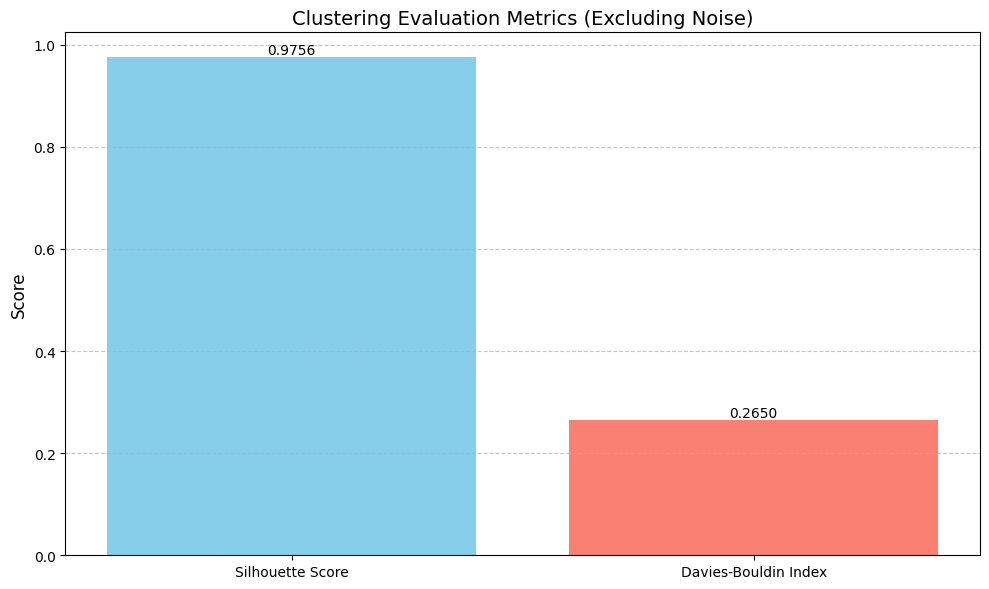

In [15]:
# Clustering evaluation metrics
non_noise_mask = cluster_labels != -1
non_noise_embeddings = embeddings[non_noise_mask]
non_noise_labels = cluster_labels[non_noise_mask]

# Calculate the metrics
silhouette_avg = silhouette_score(non_noise_embeddings, non_noise_labels)
davies_bouldin = davies_bouldin_score(non_noise_embeddings, non_noise_labels)

# Print the metrics
print(f"Silhouette Score (excluding noise): {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index (excluding noise): {davies_bouldin:.4f}")

# Prepare data for plotting
metrics = {
    'Silhouette Score': silhouette_avg,
    'Davies-Bouldin Index': davies_bouldin
}

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'])
plt.title('Clustering Evaluation Metrics (Excluding Noise)', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# Display the analization of the each cluster to select the meta_categories names

In [16]:
# Analyze clusters
print("\nCluster Analysis for Naming:")
cluster_word_freq = {}
for cluster in sorted(set(cluster_labels)):
    if cluster == -1:
        print(f"\nNoise Cluster (-1) (Size: {(cluster_labels == -1).sum()}):")
        print("Sample combined:")
        noise_data = balanced_data[balanced_data['cluster'] == -1]
        sample = noise_data[['cleaned_combined']].head(10).values
        for i, (cleaned) in enumerate(sample, 1):
            print(f"{i}.Cleaned: {cleaned}")
        # Infer top words for noise
        all_words = ' '.join(noise_data['cleaned_combined']).replace(',', '').split()
        cluster_word_freq[-1] = Counter(all_words).most_common(10)
        continue
    cluster_data = balanced_data[balanced_data['cluster'] == cluster]
    print(f"\nCluster {cluster} (Size: {len(cluster_data)}):")
    print("Sample combined:")
    sample = cluster_data[['cleaned_combined']].head(10).values
    for i, (cleaned) in enumerate(sample, 1):
        print(f"{i}.Cleaned: {cleaned}")
    all_words = ' '.join(cluster_data['cleaned_combined']).replace(',', '').split()
    word_freq = Counter(all_words).most_common(10)
    cluster_word_freq[cluster] = word_freq
    print("Top Words:", ', '.join([f"{word} ({count})" for word, count in word_freq]))



Cluster Analysis for Naming:

Noise Cluster (-1) (Size: 780):
Sample combined:
1.Cleaned: ['brand kindle ips tablet blue frys, software books, ereaders accessories, tablet cases covers, tablet accessories, computer accessories']
2.Cleaned: ['brand kindle ips tablet blue frys, software books, ereaders accessories, tablet cases covers, tablet accessories, computer accessories']
3.Cleaned: ['brand kindle ips tablet blue kindle ereaders, electronics features, computers tablets, ereaders accessories, ereaders, ebook readers']
4.Cleaned: ['brand kindle ips tablet blue kindle ereaders, electronics features, computers tablets, ereaders accessories, ereaders, ebook readers']
5.Cleaned: ['brand kindle ips tablet blue kindle ereaders, electronics features, computers tablets, ereaders accessories, ereaders, ebook readers']
6.Cleaned: ['brand kindle ips tablet blue kindle ereaders, electronics features, computers tablets, ereaders accessories, ereaders, ebook readers']
7.Cleaned: ['brand kindle ip

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


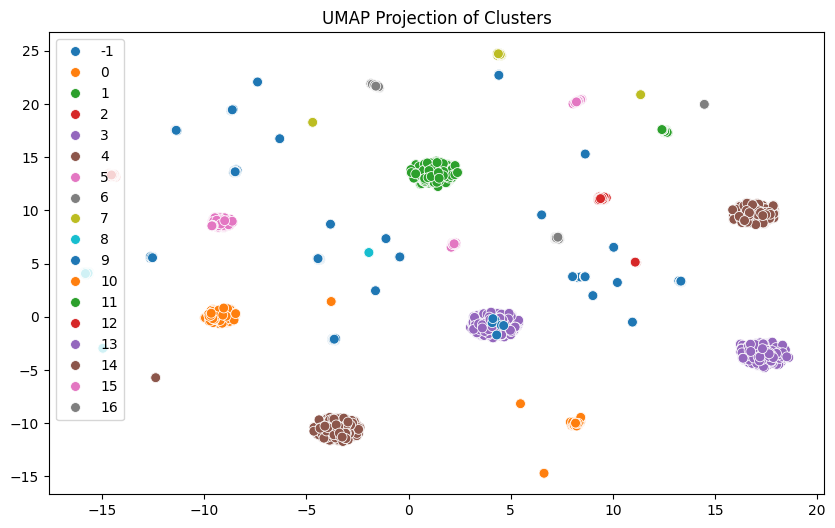

In [17]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Plot with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=cluster_labels, palette="tab10", s=50)
plt.title('UMAP Projection of Clusters')
plt.show()


# Define and name the meta_categories using GPT3


In [ ]:
""""

#Extract top keywords per cluster
def extract_top_words_per_cluster(balanced_data, cluster_col='cluster', text_col='cleaned_combined', top_n=10):
    cluster_keywords = {}
    for cluster in balanced_data[cluster_col].unique():
        words = (
            " ".join(balanced_data[balanced_data[cluster_col] == cluster]['cleaned_combined'].dropna().str.lower())
            .split()
        )
        top_words = [word for word, _ in Counter(words).most_common(top_n)]
        cluster_keywords[cluster] = top_words
    return cluster_keywords


#Generate meta-categories using sample rows
def generate_meta_categories_with_gpt(balanced_data, cluster_col='cluster', text_col='combined', model="gpt-3.5-turbo", sample_size=5):
    # Few-shot examples to guide GPT
    few_shot_examples = """
    ## Few-Shot Examples:
    Cluster 0 Examples:
    - iPhone 13 Pro Max case
    - Apple Lightning cable
    - Samsung Galaxy S21 charger
    Meta-Category: Phones

    Cluster 1 Examples:
    - Echo Dot 4th Gen with Alexa
    - Smart TV Fire Stick 4K
    - Amazon Alexa smart speaker
    Meta-Category: Speakers

    Cluster 2 Examples:
    - Kindle Paperwhite e-reader
    - Amazon Fire HD 8 tablet
    - Kobo eReader cover
    Meta-Category: Readers
    """

    prompt = f"{few_shot_examples}\n## Your Task:\nYou are helping categorize product clusters. Below are sample product examples from each cluster:\n\n"

    for cluster in sorted(balanced_data[cluster_col].unique()):
        examples = balanced_data[balanced_data[cluster_col] == cluster]['cleaned_combined'].dropna().tolist()
        if len(examples) > sample_size:
            examples = random.sample(examples, sample_size)
        prompt += f"Cluster {cluster} Examples:\n"
        for item in examples:
            prompt += f"- {item}\n"

    prompt += (
        "\nPlease group or merge the clusters based on their content into **4 to 6** meta-categories."
        " Use unique, clear, one-word names. Do **not** repeat words like 'Amazon', 'Fire', 'Kids', or generic terms."
        " Return the result as a dictionary like: {cluster_number: 'MetaCategoryName'}"
    )

    # Use OpenAI to generate the meta category mapping
    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=300,
        temperature=0.5,
    )

    # Convert the response string into a dictionary
    return eval(response.choices[0].message.content.strip())


#Assign the generated meta-category names to data
def assign_meta_categories(data, meta_mapping, cluster_col='cluster'):
    data['meta_category'] = data[cluster_col].map(meta_mapping)
    return data




cluster_keywords = extract_top_words_per_cluster(balanced_data, cluster_col='cluster', text_col='combined')

# generate meta categories based on sample rows
meta_mapping = generate_meta_categories_with_gpt(balanced_data, cluster_col='cluster', text_col='combined')

# Assign meta_category to your dataset
oversampled_data = assign_meta_categories(balanced_data, meta_mapping)
""

# Visualize to show each meta_category and it's data points

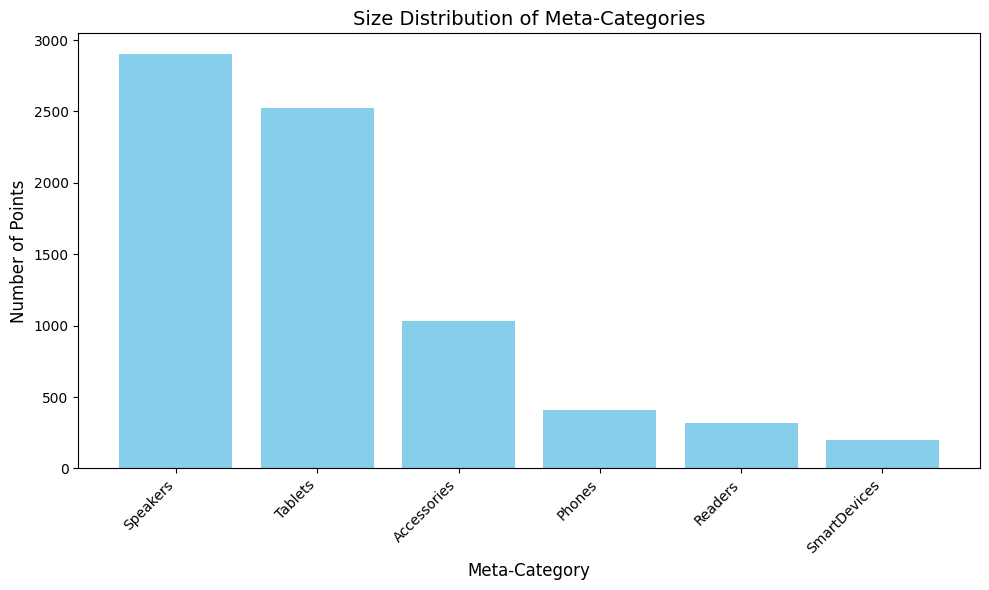

In [19]:
# Count number of items in each meta-category
meta_sizes = balanced_data['meta_category'].value_counts()

# Visualization: Bar Chart for Size Distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(meta_sizes.index, meta_sizes.values, color='skyblue')
plt.title('Size Distribution of Meta-Categories', fontsize=14)
plt.xlabel('Meta-Category', fontsize=12)
plt.ylabel('Number of Points', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Visualize the top words for each meta_category

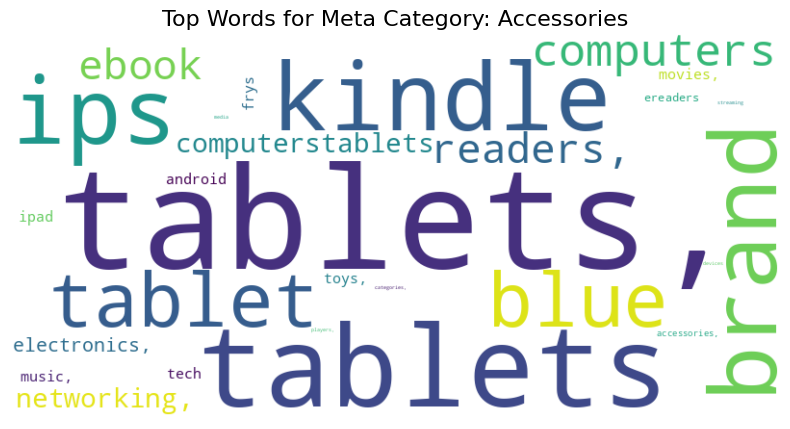

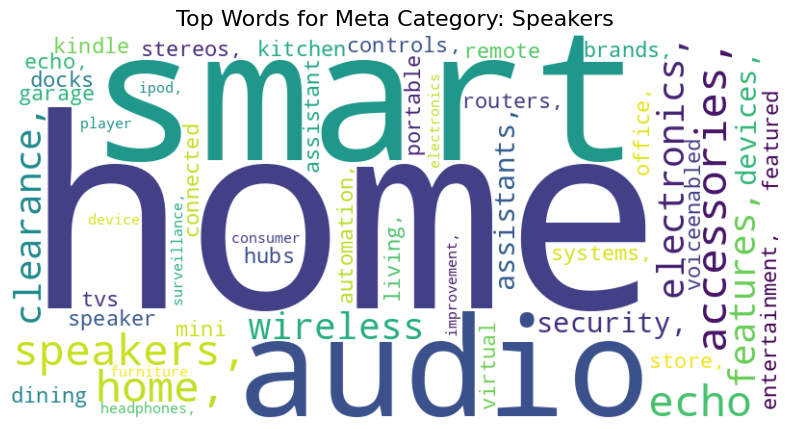

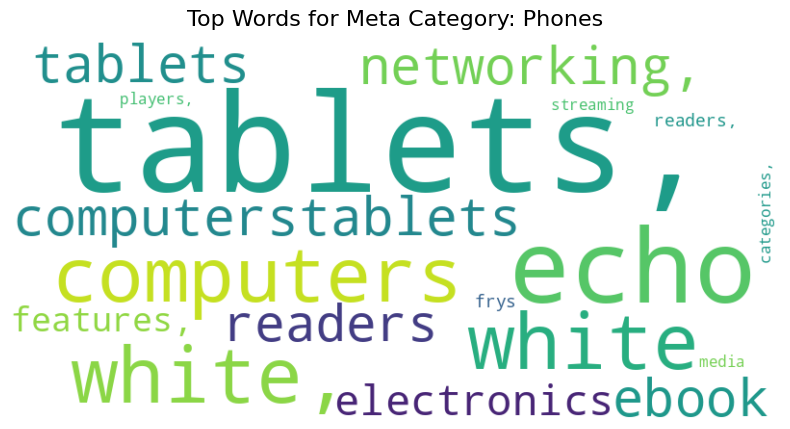

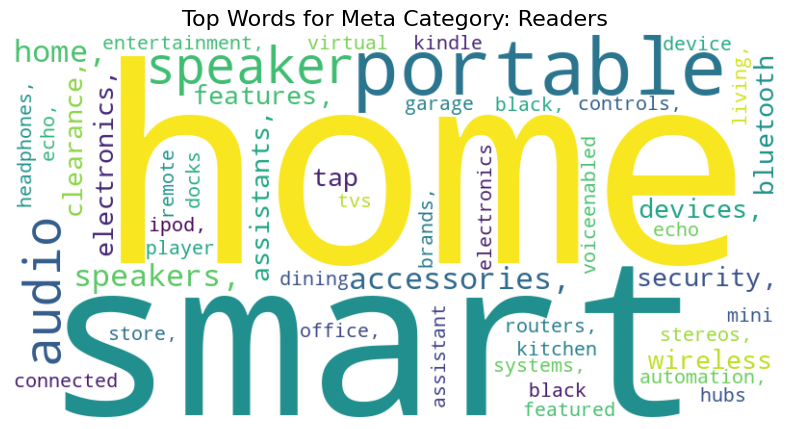

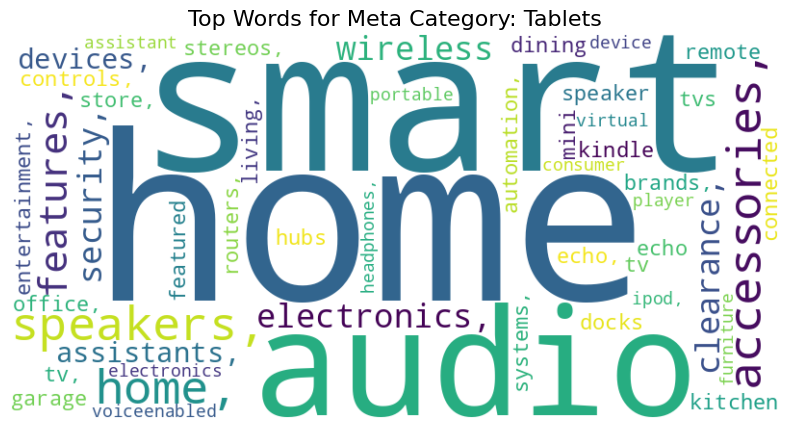

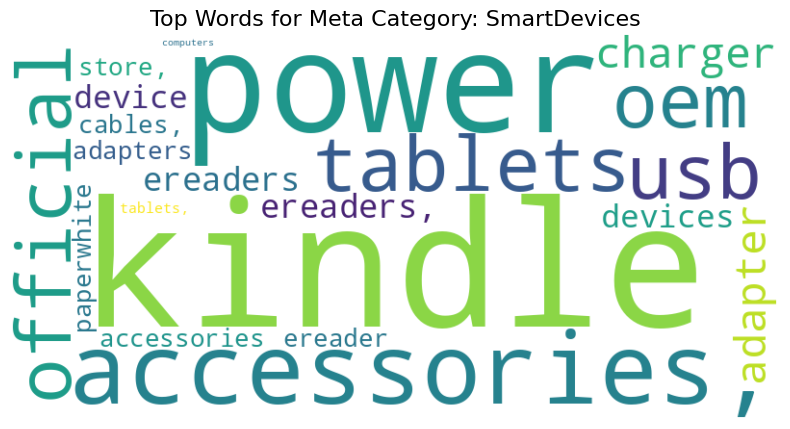

In [20]:
def visualize_top_words_per_meta_category(data, category_col='meta_category', text_col='cleaned_combined', top_n=50):
    meta_categories = data[category_col].dropna().unique()

    for meta_cat in meta_categories:
        texts = data[data[category_col] == meta_cat][text_col].dropna().str.lower().str.cat(sep=" ")
        word_counts = Counter(texts.split())
        top_words = dict(word_counts.most_common(top_n))

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Top Words for Meta Category: {meta_cat}", fontsize=16)
        plt.show()

visualize_top_words_per_meta_category(oversampled_data, category_col='meta_category', text_col='cleaned_combined')



# Save results with meta-category labels


In [21]:
# Save SentenceTransformer model
model.save("sentence_transformer_model_2")  # Saves in a folder
shutil.make_archive("sentence_transformer_model_2", 'zip', "sentence_transformer_model_2")

# Save HDBSCAN model
with open("hdbscan_model_2.pkl", "wb") as f:
    pickle.dump(clusterer, f)